# Inference in Denoising Diffusion Probabilistic Models (DDPM)

**Goals for this notebook**

1. Provide formal definitions and concise derivation of the reverse (inference) process used in DDPMs. Math is written with `$...$`.
2. Implement the forward noising $q(x_t\mid x_0)$ on MNIST and visualize noisy images at multiple timesteps.
3. Implement a step-by-step reverse (inference) sampling loop $p_\theta(x_{t-1}\mid x_t)$ using a placeholder noise-predictor network to demonstrate the algorithmic steps and print intermediate values.
4. Plot 2D and 3D visualizations that clarify the denoising trajectory and final sampled images.
5. Keep all computations explicit with printed shapes and scalar summaries so each step can be followed precisely.


# Definitions and derivation (mathematics)

**Forward (diffusion) process.** For $t=1,\dots,T$ define
$$
q(x_t \mid x_{t-1}) = \mathcal{N}\big(x_t;\ \sqrt{\alpha_t}\,x_{t-1},\ \beta_t I\big),
\qquad \alpha_t = 1-\beta_t.
$$
By marginalizing we have the closed-form:
$$
q(x_t \mid x_0) = \mathcal{N}\big(x_t;\ \sqrt{\bar\alpha_t}\,x_0,\ (1-\bar\alpha_t)I\big),
\qquad \bar\alpha_t = \prod_{s=1}^t \alpha_s.
$$

**Reverse (generative) process.** The model learns Gaussian reverse kernels:
$$
p_\theta(x_{t-1}\mid x_t) = \mathcal{N}\big(x_{t-1};\ \mu_\theta(x_t,t),\ \Sigma_t\big).
$$

Under the common $\epsilon$-prediction parameterization the model predicts noise $\epsilon_\theta(x_t,t)$ and the analytic expression for the posterior mean of $q(x_{t-1}\mid x_t,x_0)$ leads to a convenient learned mean:
$$
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t,t)\right).
$$
Then the sampling step is:
$$
x_{t-1} = \mu_\theta(x_t,t) + \sigma_t z,\qquad z\sim\mathcal N(0,I),
$$
where $\sigma_t^2$ is a (typically fixed) variance schedule (often derived from $\beta_t$).

**High-level inference algorithm (summary):**
1. Sample $x_T\sim\mathcal N(0,I)$.
2. For $t=T,\dots,1$:
   - compute $\epsilon_\theta(x_t,t)$,
   - compute $\mu_\theta(x_t,t)$ via the formula above,
   - sample $x_{t-1}\sim\mathcal N(\mu_\theta(x_t,t),\sigma_t^2 I)$.
3. Return $x_0$.


In [1]:
# Python cell: imports & device
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


Batch shapes: torch.Size([64, 1, 28, 28]) torch.Size([64])


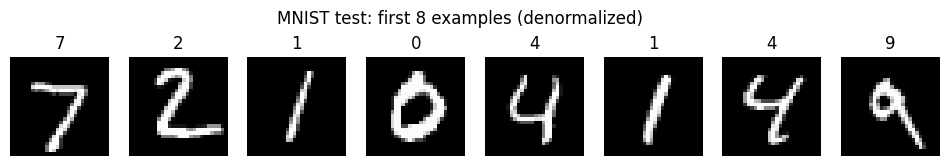

In [2]:
# Python cell: load MNIST and show example batch
transform = transforms.Compose([
    transforms.ToTensor(),               # [0,1]
    transforms.Normalize((0.5,), (0.5,)) # map to [-1,1]
])

mnist_test = datasets.MNIST(root="mnist_data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

imgs, labs = next(iter(loader))
print("Batch shapes:", imgs.shape, labs.shape)

# show first 8 images (denormalized back to [0,1])
fig, axes = plt.subplots(1,8, figsize=(12,2))
for i in range(8):
    im = imgs[i].cpu().squeeze(0) * 0.5 + 0.5
    axes[i].imshow(im, cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
    axes[i].set_title(int(labs[i].item()))
plt.suptitle("MNIST test: first 8 examples (denormalized)")
plt.show()


T: 100
beta[0], beta[-1]: 9.999999747378752e-05 0.019999999552965164
alpha_bars[0:5]: [0.9999     0.99959904 0.99909717 0.9983948  0.9974922 ]


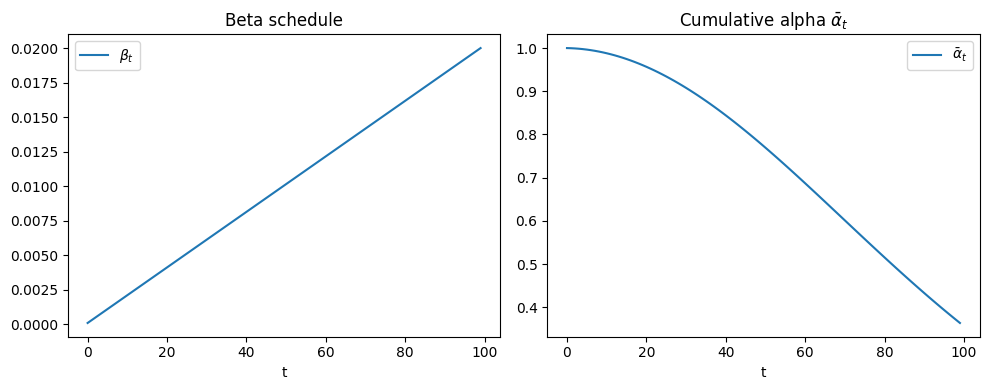

In [5]:
# Python cell: schedule and plots
T = 100  # diffusion steps for demonstration; typical research uses 1000
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

print("T:", T)
print("beta[0], beta[-1]:", float(betas[0]), float(betas[-1]))
print("alpha_bars[0:5]:", alpha_bars[:5].numpy())

plt.figure(figsize=(10,4))

# ---- Left plot: beta schedule ----
plt.subplot(1,2,1)
plt.plot(betas.numpy(), label=r'$\beta_t$')
plt.title('Beta schedule')
plt.xlabel('t')
plt.legend()

# ---- Right plot: cumulative alpha ----
plt.subplot(1,2,2)
plt.plot(alpha_bars.numpy(), label=r'$\bar{\alpha}_t$')
plt.title(r'Cumulative alpha $\bar{\alpha}_t$')
plt.xlabel('t')
plt.legend()

plt.tight_layout()
plt.show()


Original image min/max (denorm): 0.0 1.0


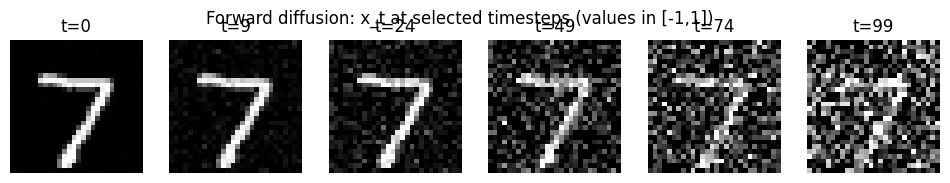

In [6]:
# Python cell: q(x_t | x_0) sampling utility and visualization
def q_sample(x0, t, noise=None):
    """Return x_t sampled from q(x_t | x0) in closed form for a batch.
       t is integer scalar in [0, T-1]."""
    if noise is None:
        noise = torch.randn_like(x0)
    a_bar = torch.sqrt(alpha_bars[t]).to(x0.device)
    b_sqrt = torch.sqrt(1.0 - alpha_bars[t]).to(x0.device)
    return a_bar.view(1,1,1,1) * x0 + b_sqrt.view(1,1,1,1) * noise, noise

# select one image to visualize forward corruption
x0 = imgs[0:1].to(device)  # shape (1,1,28,28)
timesteps_viz = [0, 9, 24, 49, 74, 99]  # selected timesteps
noisy_list = []
print("Original image min/max (denorm):", float((x0*0.5+0.5).min()), float((x0*0.5+0.5).max()))

for t in timesteps_viz:
    x_t, eps = q_sample(x0, t)
    noisy_list.append((t, x_t.detach().cpu().squeeze().numpy()))

# plot grid
cols = len(noisy_list)
fig, axes = plt.subplots(1, cols, figsize=(2*cols,2))
for i, (t, arr) in enumerate(noisy_list):
    axes[i].imshow(arr, cmap='gray', vmin=-1, vmax=1)
    axes[i].axis('off')
    axes[i].set_title(f"t={t}")
plt.suptitle("Forward diffusion: x_t at selected timesteps (values in [-1,1])")
plt.show()


# Reverse sampling formula

At each reverse step we compute the predicted mean:
$$
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t,t)\right).
$$

Then sample:
$$
x_{t-1} = \mu_\theta(x_t,t) + \sigma_t z,\quad z\sim\mathcal N(0,I).
$$

Practical notes:
- $\epsilon_\theta(x_t,t)$ is the network output predicting noise used in $q(x_t\mid x_0)$.
- $\sigma_t^2$ can be set to $\tilde\beta_t$ derived from betas or to a smaller variance for deterministic sampling (DDIM-style). Here we use $\sigma_t^2 = \beta_t$ for simplicity in demonstration.
- To visualize inference, we will use a small CNN that predicts $\epsilon_\theta(x_t,t)$; for demonstration we run sampling with this (untrained) network to illustrate the computation and show intermediate values. In practice, $\epsilon_\theta$ is a trained U-Net.


In [7]:
# Python cell: small epsilon predictor (placeholder) and mu computation
class SmallEpsPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1)
        )
    def forward(self, x, t=None):
        # t ignored in this placeholder; real models condition on t (via embeddings)
        return self.net(x)

eps_model = SmallEpsPredictor().to(device)
eps_model.eval()

def compute_mu(x_t, t_index, eps_pred):
    """Compute mu_theta according to the formula above.
       x_t and eps_pred are tensors (B,1,28,28). t_index is integer 0..T-1."""
    at = alphas[t_index].to(x_t.device)
    abar = alpha_bars[t_index].to(x_t.device)
    coef1 = 1.0 / math.sqrt(at.item())
    coef2 = (1.0 - at.item()) / math.sqrt(1.0 - abar.item())
    mu = coef1 * (x_t - coef2 * eps_pred)
    return mu

# quick sanity check on shapes and dtype
x_test = imgs[0:4].to(device)
eps_pred = eps_model(x_test)
print("x_test shape:", x_test.shape, "eps_pred shape:", eps_pred.shape)
mu_test = compute_mu(x_test, 10, eps_pred)
print("mu_test shape:", mu_test.shape)


x_test shape: torch.Size([4, 1, 28, 28]) eps_pred shape: torch.Size([4, 1, 28, 28])
mu_test shape: torch.Size([4, 1, 28, 28])


Starting x_T statistics: mean -0.0110, std 1.0199
t= 99 | x_t mean=-0.0110 std=1.0199 | mu mean=-0.0083 sigma=0.14142
t= 98 | x_t mean=-0.0079 std=1.0414 | mu mean=-0.0051 sigma=0.14071
t= 97 | x_t mean=-0.0026 std=1.0615 | mu mean=+0.0002 sigma=0.13999
t= 96 | x_t mean=-0.0013 std=1.0841 | mu mean=+0.0015 sigma=0.13927
t= 95 | x_t mean=+0.0018 std=1.1045 | mu mean=+0.0047 sigma=0.13855
t= 94 | x_t mean=+0.0055 std=1.1233 | mu mean=+0.0084 sigma=0.13782
t= 90 | x_t mean=+0.0144 std=1.2024 | mu mean=+0.0175 sigma=0.13487
t= 80 | x_t mean=+0.0470 std=1.3846 | mu mean=+0.0503 sigma=0.12720
t= 70 | x_t mean=+0.0728 std=1.5562 | mu mean=+0.0764 sigma=0.11904
t= 60 | x_t mean=+0.1128 std=1.7114 | mu mean=+0.1166 sigma=0.11028
t= 50 | x_t mean=+0.1519 std=1.8483 | mu mean=+0.1558 sigma=0.10075
t= 40 | x_t mean=+0.1924 std=1.9753 | mu mean=+0.1964 sigma=0.09022
t= 30 | x_t mean=+0.2379 std=2.0770 | mu mean=+0.2419 sigma=0.07830
t= 20 | x_t mean=+0.2790 std=2.1594 | mu mean=+0.2828 sigma=0.0641

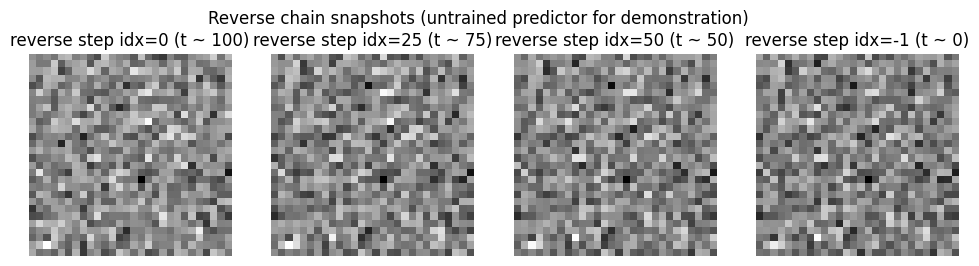

In [8]:
# Python cell: reverse sampling loop (demonstration with untrained model)
# Start from x_T ~ N(0,I)
B = 8  # generate 8 samples in parallel for visualization
sample_shape = (B, 1, 28, 28)
with torch.no_grad():
    x_t = torch.randn(sample_shape, device=device)  # x_T
    print("Starting x_T statistics: mean {:.4f}, std {:.4f}".format(x_t.mean().item(), x_t.std().item()))
    saved_images = []
    saved_stats = []

    # record initial
    saved_images.append(x_t.cpu().numpy())
    saved_stats.append((T, float(x_t.mean().item()), float(x_t.std().item())))

    for t in reversed(range(T)):
        # predict eps
        eps_pred = eps_model(x_t)            # shape (B,1,28,28)
        mu = compute_mu(x_t, t, eps_pred)   # predicted mean

        # choose sigma: here we use sigma = sqrt(beta_t) for demonstration
        sigma_t = float(torch.sqrt(betas[t]).item())
        z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)  # no noise at t=0 often
        x_prev = mu + sigma_t * z

        # printing compact numeric summaries for the first few steps, and every 10 steps later
        if t >= T-6 or (t % 10 == 0):
            print(f"t={t:3d} | x_t mean={x_t.mean().item():+.4f} std={x_t.std().item():.4f} | "
                  f"mu mean={mu.mean().item():+.4f} sigma={sigma_t:.5f}")

        saved_images.append(x_prev.cpu().numpy())
        saved_stats.append((t, float(x_prev.mean().item()), float(x_prev.std().item())))
        x_t = x_prev

# visualize selected reverse steps for one sample index (index 0)
indices_to_show = [0, len(saved_images)//4, len(saved_images)//2, -1]  # early, mid, late, final
fig, axes = plt.subplots(1, len(indices_to_show), figsize=(3*len(indices_to_show),3))
for i, idx in enumerate(indices_to_show):
    arr = saved_images[idx][0,0]  # first sample, single channel
    # denormalize not needed: model works in [-inf,inf] range; map to [0,1] via tanh-like stretch using sigmoid for visualization
    im = (arr - arr.min()) / (arr.max() - arr.min() + 1e-9)
    axes[i].imshow(im, cmap='gray')
    axes[i].set_title(f"reverse step idx={idx} (t ~ {saved_stats[idx][0]})")
    axes[i].axis('off')
plt.suptitle("Reverse chain snapshots (untrained predictor for demonstration)")
plt.show()


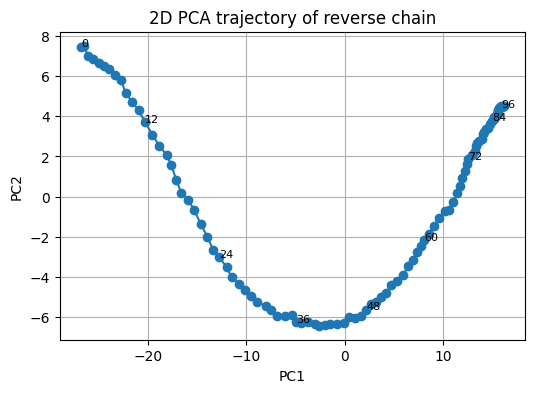

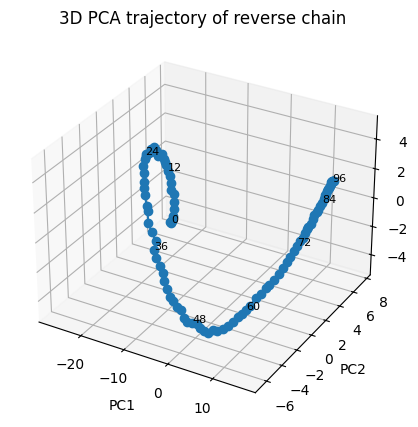

In [9]:
# Python cell: PCA of trajectory for one generated sample across reverse steps (3D)
# collect flattened vectors for first generated sample across all saved_images
all_flat = [img[0].reshape(-1) for img in saved_images]  # list of (784,)
all_mat = np.stack([arr for arr in all_flat], axis=0)    # (steps, 784)

pca = PCA(n_components=3)
proj = pca.fit_transform(all_mat)  # (steps, 3)

# 2D plot (first two principal components)
plt.figure(figsize=(6,4))
plt.plot(proj[:,0], proj[:,1], marker='o')
for i, (x,y,z) in enumerate(proj):
    if i % max(1, len(proj)//8) == 0:
        plt.text(x, y, str(i), fontsize=8)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('2D PCA trajectory of reverse chain')
plt.grid(True)
plt.show()

# 3D plot
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(proj[:,0], proj[:,1], proj[:,2], marker='o')
for i, (x,y,z) in enumerate(proj):
    if i % max(1, len(proj)//8) == 0:
        ax.text(x, y, z, str(i), size=8)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('3D PCA trajectory of reverse chain')
plt.show()


# Notes and interpretation

1. The code above demonstrates the **algorithmic steps** of DDPM inference:
   - start from $x_T\sim\mathcal N(0,I)$,
   - repeatedly compute $\epsilon_\theta(x_t,t)$, $\mu_\theta(x_t,t)$ and sample $x_{t-1}$.

2. The placeholder `eps_model` is untrained; printed statistics and final images therefore do not resemble real MNIST digits. With a trained $\epsilon_\theta$ (e.g., a U-Net trained with the standard DDPM loss), the same loop will gradually denoise to realistic images.

3. The PCA 2D/3D plots show how the high-dimensional vector representing the image moves through data space as the reverse chain progresses. These visualizations help build intuition about denoising as a trajectory from noise to data manifold.

4. For production / research:
   - replace `SmallEpsPredictor` with a U-Net conditioned on timestep embedding,
   - load trained weights for $\epsilon_\theta$ before running the reverse loop,
   - consider using $\sigma_t^2$ derived from the exact posterior (or use DDIM for deterministic sampling).

# Suggested next tasks
- Train the `epsilon` network (U-Net) on MNIST with standard DDPM training loss, then run the same reverse loop to produce realistic samples.
- Implement stochastic vs deterministic samplers (DDPM vs DDIM) and compare sample quality / speed.
